# CNN - EfficientNet

In [1]:
import os
import pandas as pd
import numpy as np
import time

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim


import matplotlib.pyplot as plt

from torchvision import models
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report 

## Loading Dataset

In [2]:
path = os.path.realpath('data/animal_10')
list_path = path.split('/')
list_path.remove('animal_cnn')
list_path.remove('animal-project')
path_training = os.path.join('/'.join(list_path), 'raw-img_training')
path_training

'/home/viviane/projects/data/animal_10/raw-img_training'

In [3]:
dataset = datasets.ImageFolder(
    root=path_training, 
    transform=transforms.ToTensor()
)
classes = dataset.classes
print(classes)

['butterfly', 'cat', 'cow', 'dog', 'elephant', 'hen', 'horse', 'sheep', 'spider', 'squirrel']


In [4]:
path = os.path.realpath('data/animal_10')
list_path = path.split('/')
list_path.remove('animal_cnn')
list_path.remove('animal-project')
path_val = os.path.join('/'.join(list_path), 'raw_img_test')
path_val

'/home/viviane/projects/data/animal_10/raw_img_test'

In [5]:
train_dir = path_training
val_dir = path_val

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

## Preprocessing

In [7]:
# Define data augmentation for the training dataset
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),   # Random crop and resize
    transforms.RandomHorizontalFlip(p=0.5),     # Random horizontal flip
    transforms.RandomRotation(20),              # Random rotation within ±20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),  # Shearing
    transforms.ToTensor(),                      # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize
])

# Define validation dataset - no augmentation, only resizing and normalization
val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# split train_dataset and load
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=val_transforms)

train_size = int(0.8 * len(train_dataset))  # 80% for training
test_size = len(train_dataset) - train_size  # Remaining for testing

train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

# Define loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}, Validation samples: {len(val_dataset)}')

Training samples: 10472, Test samples: 2619, Validation samples: 13091


In [8]:
print(f'Training samples: {len(train_loader)}, Test samples: {len(test_loader)}, Validation samples: {len(val_loader)}')

Training samples: 655, Test samples: 164, Validation samples: 819


## Architecture

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10

model = models.efficientnet_b0(weights=None) 
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [16, 10]                  --
├─Sequential: 1-1                                       [16, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [16, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [16, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [16, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [16, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [16, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [16, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [16, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [16, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

In [11]:
## Training

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Metrics
    confusion_matrix = MulticlassConfusionMatrix(num_classes=10)
    precision = MulticlassPrecision(num_classes=10, average='macro')
    recall = MulticlassRecall(num_classes=10, average='macro')
    f1_score = MulticlassF1Score(num_classes=10, average='macro')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluation part to print metrics for each epoch
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

                # For metrics
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        
        precision_value = precision(all_preds, all_labels)
        recall_value = recall(all_preds, all_labels)
        f1_value = f1_score(all_preds, all_labels)
        conf_matrix = confusion_matrix(all_preds, all_labels)

        
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}%")
        print(f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%")
        print(f"Precision: {precision_value:.4f} | Recall: {recall_value:.4f} | F1 Score: {f1_value:.4f}\n")

    return train_losses, val_losses, train_accuracies, val_accuracies, conf_matrix

In [13]:
t1 = time.time()
print(f"Using device: {device}")

train_losses, val_losses, train_accuracies, val_accuracies, conf_matrix = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=50)

print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Using device: cuda
Epoch 1/50
Train Loss: 2.2014 | Train Acc: 21.40%
Val Loss: 2.2719 | Val Acc: 23.79%
Precision: 0.0893 | Recall: 0.1468 | F1 Score: 0.1042

Epoch 2/50
Train Loss: 2.1187 | Train Acc: 24.93%
Val Loss: 2.4744 | Val Acc: 22.79%
Precision: 0.1334 | Recall: 0.1550 | F1 Score: 0.1230

Epoch 3/50
Train Loss: 2.0871 | Train Acc: 26.07%
Val Loss: 2.0509 | Val Acc: 28.37%
Precision: 0.1325 | Recall: 0.1745 | F1 Score: 0.1260

Epoch 4/50
Train Loss: 2.0342 | Train Acc: 28.80%
Val Loss: 1.9712 | Val Acc: 32.68%
Precision: 0.2198 | Recall: 0.2314 | F1 Score: 0.1921

Epoch 5/50
Train Loss: 1.9603 | Train Acc: 31.20%
Val Loss: 1.9089 | Val Acc: 32.26%
Precision: 0.1928 | Recall: 0.2287 | F1 Score: 0.1968

Epoch 6/50
Train Loss: 1.9050 | Train Acc: 32.92%
Val Loss: 1.8493 | Val Acc: 33.45%
Precision: 0.2117 | Recall: 0.2382 | F1 Score: 0.2080

Epoch 7/50
Train Loss: 1.8476 | Train Acc: 35.25%
Val Loss: 1.7496 | Val Acc: 38.41%
Precision: 0.3098 | Recall: 0.2992 | F1 Score: 0.2822

E

## Evaluating

In [14]:
model.eval() 

with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Test Accuracy of the model on the {total} test images: {(correct / total) * 100:.2f}%')

Test Accuracy of the model on the 2619 test images: 73.35%


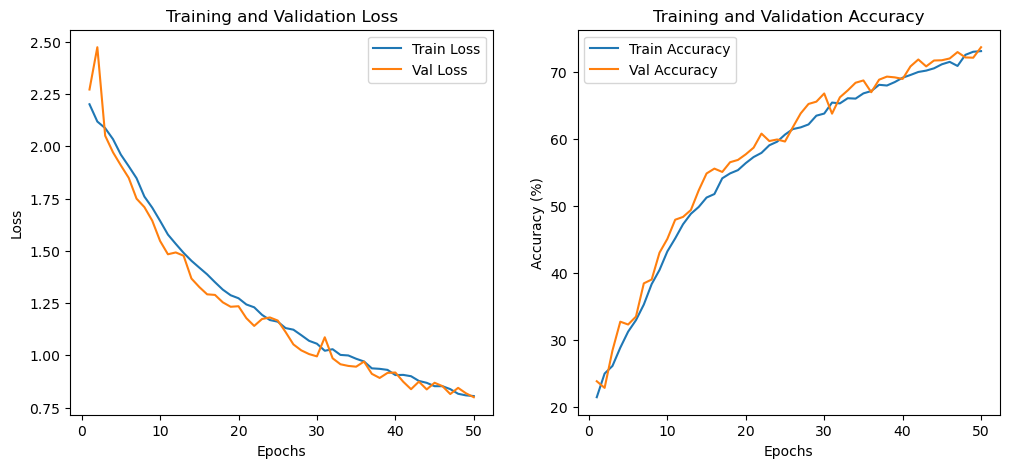

In [15]:
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

plot_training(train_losses, val_losses, train_accuracies, val_accuracies)

In [16]:
### Confusion Matrix

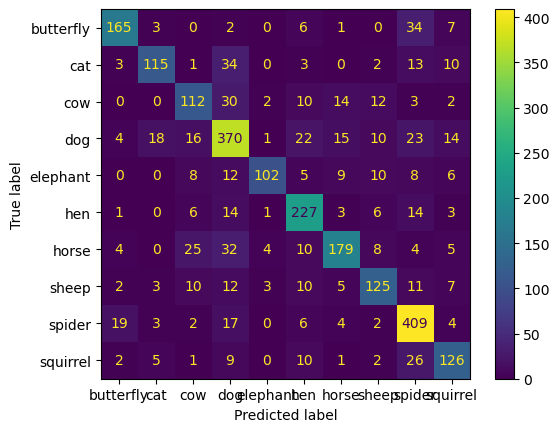

In [17]:
cm = conf_matrix.cpu().numpy()
disp = ConfusionMatrixDisplay(cm, display_labels=classes,)
disp.plot()

### Metrics

In [18]:
precision = MulticlassPrecision(num_classes=num_classes, average=None)
recall = MulticlassRecall(num_classes=num_classes, average=None)
f1_score = MulticlassF1Score(num_classes=num_classes, average=None)


all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())


all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)


per_class_precision = precision(all_preds, all_labels)
per_class_recall = recall(all_preds, all_labels)
per_class_f1 = f1_score(all_preds, all_labels)


for i, name in enumerate(classes):
    print(f"Class {i}-{name}: Precision: {per_class_precision[i]:.2f}, Recall: {per_class_recall[i]:.2f}, F1-Score: {per_class_f1[i]:.2f}")

Class 0-butterfly: Precision: 0.85, Recall: 0.84, F1-Score: 0.84
Class 1-cat: Precision: 0.81, Recall: 0.58, F1-Score: 0.68
Class 2-cow: Precision: 0.65, Recall: 0.72, F1-Score: 0.68
Class 3-dog: Precision: 0.81, Recall: 0.77, F1-Score: 0.79
Class 4-elephant: Precision: 0.91, Recall: 0.66, F1-Score: 0.77
Class 5-hen: Precision: 0.86, Recall: 0.86, F1-Score: 0.86
Class 6-horse: Precision: 0.72, Recall: 0.79, F1-Score: 0.75
Class 7-sheep: Precision: 0.72, Recall: 0.80, F1-Score: 0.75
Class 8-spider: Precision: 0.87, Recall: 0.94, F1-Score: 0.90
Class 9-squirrel: Precision: 0.75, Recall: 0.79, F1-Score: 0.77
